<a href="https://colab.research.google.com/github/EAliakbar/Golestan-Catpcha-Breaker/blob/master/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset file

In [0]:
#todo
from PIL import Image
import csv
from tqdm import tqdm
import cv2
import numpy as np
from matplotlib import pyplot as plt
# IMG_DIR = '~/AI/data'
IMG_DIR = './raw/'

In [0]:
example_image_path = IMG_DIR + '8.gif'

In [62]:
# !wget https://github.com/EN10/KerasMNIST/raw/master/cnn.h5
# !wget https://github.com/shubhammor0403/EMNIST/raw/master/model.h5
# !wget https://github.com/shubhammor0403/EMNIST/raw/master/model.json

In [0]:
#!wget http://ai.winstonlcc.tk/data.tar.gz
# !wget http://ai.winstonlcc.tk/export.csv
#!tar xzf data.tar.gz
# !mv newdata raw

In [0]:
from google.colab import files
uploaded = files.upload()

Convert to black and white

In [0]:
def sharp_img(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_image = cv2.blur(gray_img, (4, 4))
    gblur_img = cv2.GaussianBlur(blur_image, (0, 0), 6)
    sharp_img = cv2.addWeighted(gray_img, 1.80, gblur_img, -0.60, 0)
    sharp_not_img = cv2.bitwise_not(sharp_img);
    retval, img_zeroone = cv2.threshold(sharp_not_img, 20, 255, cv2.THRESH_BINARY)
    return img_zeroone

(50, 140, 3)


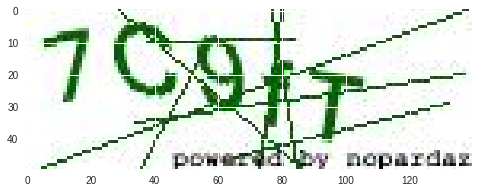

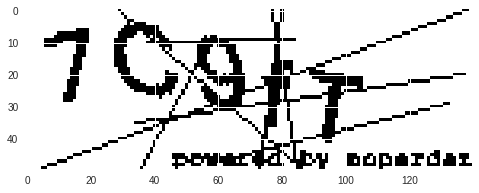

In [44]:
im = cv2.imread(example_image_path)
print(im.shape)
sim = sharp_img(im)
plt.imshow(im)
plt.show()
plt.imshow(sim)
plt.show()

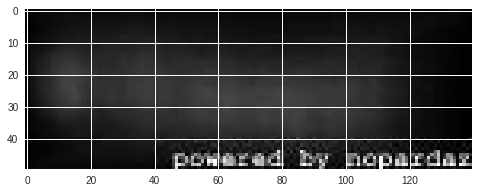

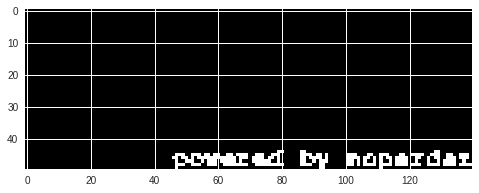

In [29]:
im  = cv2.imread('mask.jpg')

mask = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im)
plt.show()

retval, t_mask = cv2.threshold(mask, 70, 255, cv2.THRESH_BINARY)

masker = cv2.bitwise_not(t_mask)

plt.imshow(masker)
plt.show()

In [0]:
def clear_img(img):
  unmasked = cv2.bitwise_and(img, masker)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
  opening_img = cv2.morphologyEx(unmasked, cv2.MORPH_OPEN, kernel)
  return opening_img


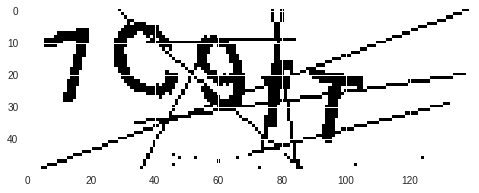

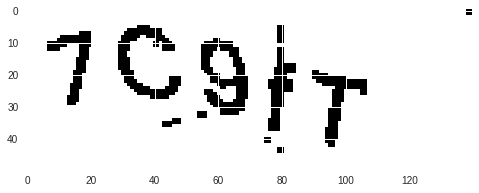

In [45]:
cl_img = clear_img(sim)

plt.imshow(cl_img)
plt.show()

In [0]:
def k_mean_crop(tag, img):
  from scipy.cluster.vq import kmeans
  points = [[0, 0] for i in range(np.count_nonzero(img))]
  (a, b) = img.shape
  k = 0
  for i in range(a):
    for j in range(b):
      if img[i][j] > 0:
        points[k][0] = i
        points[k][1] = j
        k += 1
  points = np.asarray(points)
  codebook = kmeans(points.astype(float), 5)

  cbimg = np.array([[0 for l in range(140)] for i in range(50)])
  for d in codebook[0]:
    cbimg[int(d[0])][int(d[1])] = 255

  codebook = codebook[0].astype(int)

  ctr = 0
  # img_name = img_path.split('.')[0]
  # captcha_name = input()
  sortedbook = sorted(codebook, key=lambda i: i[1])
  for i in sortedbook:
    x = max(i[0], 14)
    y = max(i[1], 14)
    x = min(x, 36)
    y = min(y, 126)
    croped_img = img[x - 14:x + 14, y - 14:y + 14]
    yield tag[ctr], croped_img
    ctr += 1
#     plt.imshow(croped_img)
#     plt.show()

In [0]:
def contour_crop(tag, img):
  im2,ctrs, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  plt.imshow(im2)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
    print(x,y,w,h)
    # Getting ROI
    roi = img[y-10:y+h+10, x-10:x+w+10]
    print(roi.shape)
    roi = cv2.resize(roi, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
    roi = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    yield tag[i], roi

In [107]:
from scipy.misc import imread, imresize

#perform the prediction
from keras.models import load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam
from keras.layers.advanced_activations import LeakyReLU
model1 = load_model('cnn.h5')


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [108]:
# x = next(k_mean_crop(opening_img))
MNIST_char_all = 0
MNIST_char_success = 0
unSuccess = []
with open('export.csv') as file:
  reader = csv.DictReader(file)
  for row in tqdm(list(reader)):
    labe = row['Label']
    if labe == 'Skip':
      continue
    labe = labe[18:23]
    img_path = IMG_DIR + row['External ID'].split('.')[0] + '.gif'
    im = cv2.imread(img_path)
    
    sim = sharp_img(im)
    cl_img = clear_img(sim)
    for label, x in k_mean_crop(labe,cl_img):
      if not label.isdigit():
        continue
      MNIST_char_all += 1
      x = np.invert(x)
#       plt.imshow(x)
#       plt.show()
      x = x = x.reshape(1,28,28,1)
      x = x.astype('float32')
      x /= 255

      out = model1.predict_classes(x)
      if str(out[0]) == label:
        MNIST_char_success += 1
      else:
        unSuccess.append((out[0], label, x))



  0%|          | 0/1002 [00:00<?, ?it/s]

  0%|          | 2/1002 [00:00<02:58,  5.59it/s]

  1%|          | 6/1002 [00:00<02:14,  7.41it/s]

  1%|          | 9/1002 [00:00<01:44,  9.54it/s]

  1%|          | 12/1002 [00:00<01:23, 11.89it/s]

  1%|▏         | 15/1002 [00:00<01:09, 14.15it/s]

  2%|▏         | 18/1002 [00:00<00:59, 16.41it/s]

  2%|▏         | 21/1002 [00:01<00:53, 18.32it/s]

  2%|▏         | 24/1002 [00:01<00:48, 20.23it/s]

  3%|▎         | 27/1002 [00:01<00:45, 21.52it/s]

  3%|▎         | 30/1002 [00:01<00:41, 23.46it/s]

  3%|▎         | 33/1002 [00:01<00:42, 22.67it/s]

  4%|▎         | 36/1002 [00:01<00:40, 23.83it/s]

  4%|▍         | 39/1002 [00:01<00:38, 24.98it/s]

  4%|▍         | 42/1002 [00:01<00:37, 25.77it/s]

  4%|▍         | 45/1002 [00:01<00:38, 24.74it/s]

  5%|▍         | 48/1002 [00:02<00:37, 25.62it/s]

  5%|▌         | 51/1002 [00:02<00:35, 26.46it/s]

  5%|▌         | 54/1002 [00:02<00:34, 27.31it/s]

  6%|▌         | 58/1002 [00:02<00:32, 29

In [109]:
print("Successful predictions: ", MNIST_char_success)
print("All predictions: ", MNIST_char_all)
print("Success Rate: ", MNIST_char_success/MNIST_char_all)

Successful predictions:  117
All predictions:  739
Success Rate:  0.15832205683355885


In [110]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights('model.h5')

model2 = loaded_model


print('Model successfully loaded')

Model successfully loaded


In [0]:
characters = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [87]:
EMNIST_char_all = 0
EMNIST_char_success = 0
EMNIST_all = 0
EMNIST_success = 0
unSuccess_EMNIST = []
with open('export.csv') as file:
  reader = csv.DictReader(file)
  for row in tqdm(list(reader)):
    labe = row['Label']
    if labe == 'Skip':
      continue
    EMNIST_all += 1
    labe = labe[18:23]
    img_path = IMG_DIR + row['External ID'].split('.')[0] + '.gif'
    im = cv2.imread(img_path)
    sim = sharp_img(im)
    cl_img = clear_img(sim)
    ret = ''
    for label, x in k_mean_crop(labe,cl_img):
      EMNIST_char_all += 1
#       x = np.invert(x)
#       plt.imshow(x)
#       plt.show()
      x = x = x.reshape(1,784)
      x = x.astype('float32')
      x /= 255

      out = model2.predict_classes(x)
      out2 = characters[out[0]]
      if str(out2.lower()) == label.lower():
        EMNIST_char_success += 1
      else:
        unSuccess_EMNIST.append((out2, label, x))
      ret = ret + out2
    if ret.lower() == labe.lower():
      EMNIST_success += 1



  0%|          | 0/1002 [00:00<?, ?it/s]

  0%|          | 3/1002 [00:00<00:47, 20.92it/s]

  1%|          | 6/1002 [00:00<00:47, 20.89it/s]

  1%|          | 8/1002 [00:00<00:48, 20.59it/s]

  1%|          | 10/1002 [00:00<00:48, 20.30it/s]

  1%|          | 12/1002 [00:00<00:49, 20.19it/s]

  1%|▏         | 15/1002 [00:00<00:48, 20.55it/s]

  2%|▏         | 17/1002 [00:00<00:49, 19.80it/s]

  2%|▏         | 19/1002 [00:00<00:50, 19.63it/s]

  2%|▏         | 21/1002 [00:01<00:50, 19.46it/s]

  2%|▏         | 23/1002 [00:01<00:50, 19.52it/s]

  2%|▏         | 25/1002 [00:01<00:49, 19.59it/s]

  3%|▎         | 27/1002 [00:01<00:49, 19.69it/s]

  3%|▎         | 30/1002 [00:01<00:48, 20.19it/s]

  3%|▎         | 33/1002 [00:01<00:49, 19.74it/s]

  3%|▎         | 35/1002 [00:01<00:50, 19.31it/s]

  4%|▍         | 38/1002 [00:01<00:49, 19.54it/s]

  4%|▍         | 41/1002 [00:02<00:48, 19.87it/s]

  4%|▍         | 44/1002 [00:02<00:46, 20.52it/s]

  5%|▍         | 47/1002 [00:02<00:46, 20

In [112]:
print("per Char Successful predictions: ", EMNIST_char_success)
print("per Char predictions: ", EMNIST_char_all)
print("per Char Success Rate: ", EMNIST_char_success/EMNIST_char_all)

print("Successful predictions: ", EMNIST_success)
print("All predictions: ", EMNIST_all)
print("Success Rate: ", EMNIST_success/EMNIST_all)

per Char Successful predictions:  3202
per Char predictions:  4950
per Char Success Rate:  0.6468686868686868
Successful predictions:  129
All predictions:  990
Success Rate:  0.1303030303030303
